In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from lightgbm import LGBMClassifier

from plots.feature_plots import plot_roc_auc, plot_confusion_matrix
from data.processed_data import load_feature_data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
# Load the processed feature data
feature_df = load_feature_data()

# Separate features and target
X = feature_df.drop(columns=["SepsisLabel"], errors="ignore")
y = feature_df["SepsisLabel"]

# Print the number of negative and positive samples
neg_samples, pos_samples = y.value_counts()
print(f"Negative samples: {neg_samples}, Positive samples: {pos_samples}")

Feature data loaded from feature_data.pkl
Negative samples: 1511067, Positive samples: 27594


In [3]:
# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Train the LightGBM model with class imbalance handling
model = LGBMClassifier(
    random_state=42,
    objective='binary',
    scale_pos_weight=neg_samples / pos_samples,
    verbose=1
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[LightGBM] [Info] Number of positive: 22075, number of negative: 1208853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50237
[LightGBM] [Info] Number of data points in the train set: 1230928, number of used features: 227
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017934 -> initscore=-4.002982
[LightGBM] [Info] Start training from score -4.002982


LGBMClassifier(objective='binary', random_state=42,
               scale_pos_weight=54.760708849749946, verbose=1)

Subset ROC AUC (predicted=1 or actual=1): 0.602


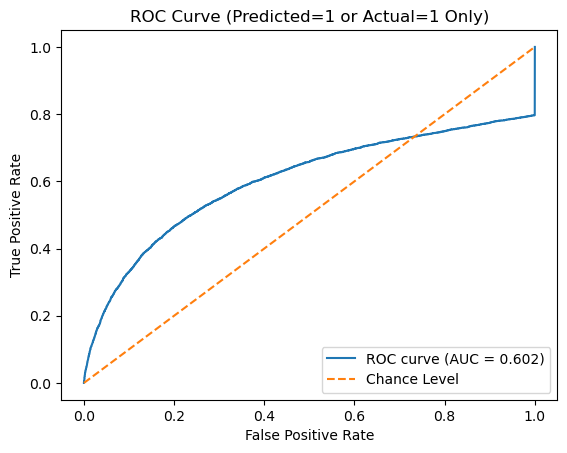

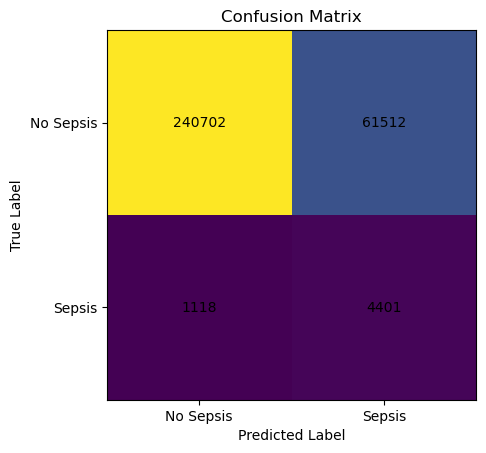


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.88    302214
           1       0.07      0.80      0.12      5519

    accuracy                           0.80    307733
   macro avg       0.53      0.80      0.50    307733
weighted avg       0.98      0.80      0.87    307733



In [4]:
# Evaluate the model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Plot ROC curve and confusion matrix
plot_roc_auc(model, X_test, y_test)
plot_confusion_matrix(y_test, y_pred, labels=("No Sepsis", "Sepsis"))

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [9]:
# Find the optimal threshold based on the F-beta score (beta=7)
thresholds = np.arange(0.0, 1.0, 0.01)
f2_scores = []
for t in thresholds:
    y_pred_threshold = (y_proba >= t).astype(int)
    f2 = fbeta_score(y_test, y_pred_threshold, beta=10)
    f2_scores.append(f2)

optimal_threshold = thresholds[np.argmax(f2_scores)]
print(f"Optimal threshold: {optimal_threshold}, F2 Score: {max(f2_scores)}")


Optimal threshold: 0.25, F2 Score: 0.7637500036516714


              precision    recall  f1-score   support

           0       1.00      0.58      0.73    302214
           1       0.04      0.94      0.07      5519

    accuracy                           0.58    307733
   macro avg       0.52      0.76      0.40    307733
weighted avg       0.98      0.58      0.72    307733

[[174673 127541]
 [   342   5177]]
Subset ROC AUC (predicted=1 or actual=1): 0.744


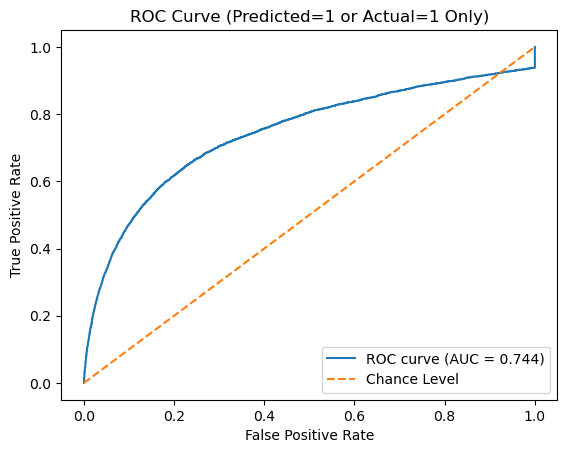

In [10]:
# Apply the new threshold for custom predictions
y_pred_custom = (y_proba >= optimal_threshold).astype(int)

# Evaluate predictions based on the optimal threshold
print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))
plot_roc_auc(model, X_test, y_test, optimal_threshold)
